In [33]:
import torch
from torch.nn.functional import relu
import numpy as np
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [34]:
aug = MNISTAug()
dm = DataManager()
dm.load_test()

In [35]:
aug.min_objects = 1
aug.max_objects = 1

{'class': 0,
 'class_one_hot': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'x1': 13,
 'y1': 1,
 'x2': 67,
 'y2': 55,
 'cx': 40.0,
 'cy': 28.0,
 'height': 54,
 'width': 54}

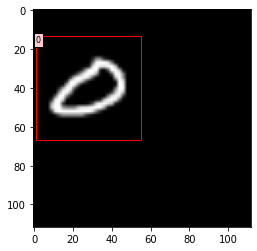

In [58]:
image, label = aug.get_augmented(dm.x_test, dm.y_test, 1)
image = image[0]
label = label[0][0]
DataManager.plot_num(image.reshape((112, 112)), [label])
label

In [59]:
op_w = 64
op_h = 64

in_w = 112
in_h = 112

In [60]:
def add_scalar_noise(value, scale=0.01):
    return value + (np.random.random((1,))[0] - 0.5) * scale

cx = add_scalar_noise(label['cx'] / in_w)
cy = add_scalar_noise(label['cy'] / in_h)
w = add_scalar_noise(label['width'] / in_w)
h = add_scalar_noise(label['height'] / in_h)
theta = [cx, cy, w, h]

In [61]:
region_w = w * in_w
region_h = h * in_h
region_x1 = (cx * in_w) - (region_w / 2)
region_y1 = (cy * in_h) - (region_h / 2)

step_w = region_w / op_w
step_h = region_h / op_h

# TODO: Parallelize this step
grid = np.zeros((op_w, op_h, 2))
for i in range(op_w):
    for j in range(op_h):
        grid[i][j][0] = region_x1 + (i * step_w)
        grid[i][j][1] = region_y1 + (j * step_h)

In [72]:
op = np.zeros((op_w, op_h))
kernel_radius = 2

def bilinear_kernel(d):
    return max(0, 1 - abs(d))

def get_op_pixel(i, j):

    pixel = 0

    i_ = int(round(max(0, grid[i][j][0] - kernel_radius)))
    while i_ < min(in_w, grid[i][j][0] + kernel_radius - 1):

        j_ = int(round(max(0, grid[i][j][1] - kernel_radius)))
        while j_ < min(in_h, grid[i][j][1] + kernel_radius - 1):

            pixel += image[i_][j_] * bilinear_kernel(i_ - grid[i][j][0]) * bilinear_kernel(j_ - grid[i][j][1])
            j_ += 1

        i_ += 1

    return pixel


for i in range(op_w):
    for j in range(op_h):
        op[i][j] = get_op_pixel(i, j)

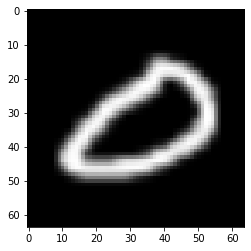

In [73]:
DataManager.plot_num(op.reshape((op_w, op_h)))